# Import libraries

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from scipy.spatial import distance

# Create grid image


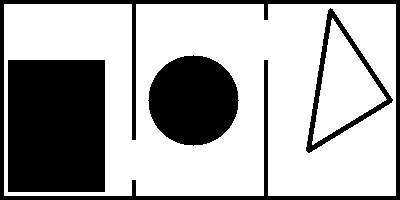

In [2]:
img_obstacles = 255*np.ones(shape = (200, 400, 3))
img_obstacles[:4, :] = (0, 0, 0) # top bar
img_obstacles[-4:, :] = (0, 0, 0) # bottom bar
img_obstacles[:, :4] = (0, 0, 0) # left bar
img_obstacles[:, -4:] = (0, 0, 0) # right bar
img_obstacles[:, 132:132+4] = (0, 0, 0) # mid left bar
img_obstacles[:, 264:264+4] = (0, 0, 0) # mid right bar
img_obstacles[140:180, 132:132+4] = (255, 255, 255) # mid left bar opening
img_obstacles[20:60, 264:264+4] = (255, 255, 255) # mid right bar opening
img_obstacles[60:-8, 8:105] = (0, 0, 0) # left rectangle
img_obstacles = cv2.circle(img_obstacles, (193, 100), 45, (0, 0, 0), -1) # mid circle
img_obstacles = cv2.line(img_obstacles, (330, 10), (390, 100), (0, 0, 0), 3) # right triangle
img_obstacles = cv2.line(img_obstacles, (308, 150), (390, 100), (0, 0, 0), 3)
img_obstacles = cv2.line(img_obstacles, (308, 150), (330, 10), (0, 0, 0), 3)
cv2_imshow(img_obstacles)

There are 3 obstacles: 1 hollow triangle, 1 disc and 1 rectangle.

In [3]:
np_obs_points = np.array(np.where((img_obstacles == [0, 0, 0]).all(axis = 2))).T # obstacle pixels indices present in the image
np_obs_points.shape # obstacle points x 2 (row, column)

(26784, 2)

In [4]:
np_white_points = np.array(np.where((img_obstacles == [255, 255, 255]).all(axis = 2))).T # white pixels indices present in the image
np_white_points.shape # obstacle free points x 2 (row, column)

(53216, 2)

# Robot initialization

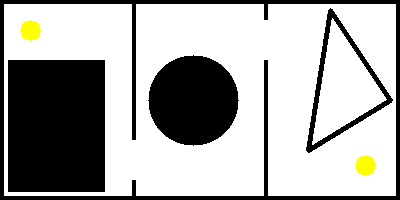

In [5]:
b = 12 # tri-cycle length
d = 5
max_steer_angle = 30*np.pi/180 # in radians
v_f = 2
robot_initial_point = (30, 30, 0) # row, col, theta
robot_final_point = (165, 365) # row, col
cv2.circle(img_obstacles, robot_initial_point[:2][::-1], 10, (0, 255, 255), -1)
cv2.circle(img_obstacles, robot_final_point[::-1], 10, (0, 255, 255), -1)
cv2_imshow(img_obstacles)

In [6]:
img_obstacles_mid = img_obstacles.copy()

# Tree node

In [7]:
np_rrt_nodes = np.array([*robot_initial_point, 0, 0]).reshape(1, -1) # current_node_r, current_node_c, current_node_theta, parent_steer_angle, parent_index
np_rrt_nodes.shape

(1, 5)

# RRT

In [8]:
def compute_motion_primitive(np_path, steer_angle):
    omega, linear_velo = v_f * np.sin(steer_angle) / b, v_f * np.cos(steer_angle)
    np_path = np_path.copy().reshape(1, -1)
    theta_back = np_path[0, 2] - np.pi
    back_coord = np.array([b*np.sin(theta_back), b*np.cos(theta_back)]) + np_path[0, :2]
    theta_wheel_1 = np_path[0, 2] - np.pi/2
    theta_wheel_2 = np_path[0, 2] + np.pi/2
    wheel_1_coord = np.array([d*np.sin(theta_wheel_1), d*np.cos(theta_wheel_1)]) + back_coord
    wheel_2_coord = np.array([d*np.sin(theta_wheel_2), d*np.cos(theta_wheel_2)]) + back_coord
    np_path_wheel_1 = np.array([*wheel_1_coord, theta_wheel_1]).reshape(1, -1)
    np_path_wheel_2 = np.array([*wheel_2_coord, theta_wheel_2]).reshape(1, -1)
    for i in range(10): # step size
        np_path = np.append(np_path, np.array([[np_path[i, 0] + linear_velo * np.sin(np_path[i, 2]), np_path[i, 1] + linear_velo * np.cos(np_path[i, 2]), np_path[i, 2] + omega]]), axis = 0)
        theta_back = np_path[-1, 2] - np.pi
        back_coord = np.array([b*np.sin(theta_back), b*np.cos(theta_back)]) + np_path[-1, :2]
        theta_wheel_1 = np_path[-1, 2] - np.pi/2
        theta_wheel_2 = np_path[-1, 2] + np.pi/2
        wheel_1_coord = np.array([d*np.sin(theta_wheel_1), d*np.cos(theta_wheel_1)]) + back_coord
        wheel_2_coord = np.array([d*np.sin(theta_wheel_2), d*np.cos(theta_wheel_2)]) + back_coord
        np_path_wheel_1 = np.append(np_path_wheel_1, np.array([[*wheel_1_coord, theta_wheel_1]]), axis = 0)
        np_path_wheel_2 = np.append(np_path_wheel_2, np.array([[*wheel_2_coord, theta_wheel_2]]), axis = 0)
    return np_path, np_path_wheel_1, np_path_wheel_2

In [9]:
out = cv2.VideoWriter('NonHolonomic 1 - RRT.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 25, img_obstacles.shape[:2][::-1])
while True:
    # fetching the random point in configuration space
    random_index = np.random.randint(0, high = len(np_white_points))
    np_q_rand = np_white_points[random_index] # row, col

    # finding the points with correct steering angle
    np_temp = np_q_rand - np_rrt_nodes[:, :2] # find the vector between two points
    np_temp = np.arctan2(np_temp[:, 0], np_temp[:, 1]) # find the angle between them
    np_temp = np.where(np.logical_and(np_temp <= max_steer_angle, -max_steer_angle <= np_temp)) # find the indices of all the points that satify the steering angle condition
    if len(np_temp[0]) == 0: continue

    # find the nearest node in the RRT tree
    np_temp = np_rrt_nodes[np_temp[0], :] # find the points in the rrt nodes that satify the steering angle condition
    np_q_near = np_temp[distance.cdist([np_q_rand], np_temp[:, :2]).argmin()] # find the minimum distance among the points satisfying the steering wheel condition
    parent_index = np.where((np_rrt_nodes == np_q_near).all(axis = 1))[0][0]

    # compute the motion primitive
    np_temp = np_q_rand - np_q_near[:2]
    steer_angle = np.arctan2(np_temp[0], np_temp[1]) # in radians
    np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(np_q_near[:3], steer_angle)
    # for i in range(len(np_path)):
    #     while np_path[i, 2] < 0: np_path[i, 2] += 2*np.pi
    #     while np_path[i, 2] > 2*np.pi: np_path[i, 2] -= 2*np.pi
    np_path[:, :2] = np.round(np_path[:, :2])
    np_path_wheel_1[:, :2] = np.round(np_path_wheel_1[:, :2])
    np_path_wheel_2[:, :2] = np.round(np_path_wheel_2[:, :2])

    # check for the validity of the path
    if distance.cdist(np_path[:, :2], np_obs_points).min() == 0: continue # collision occurred
    if distance.cdist(np_path_wheel_1[:, :2], np_obs_points).min() == 0: continue
    if distance.cdist(np_path_wheel_2[:, :2], np_obs_points).min() == 0: continue
    # if img_obstacles_mid[np_path]

    # no collision
    np_rrt_nodes = np.append(np_rrt_nodes, np.array([np_path[-1, 0], np_path[-1, 1], np_path[-1, 2], steer_angle, parent_index]).reshape(1, -1), axis = 0)
    # for i in range(1, len(np_path_final)):
    #     if np.any((np_rrt_nodes[:, :2] == [np_path_final[i, 0], np_path_final[i, 1]]).all(axis = 1)): continue
    #     if i == 0:
    #         np_rrt_nodes = np.append(np_rrt_nodes, np.array([np_path_final[i, 0], np_path_final[i, 1], np_path_final[i, 2], parent_steer_angle_final, parent_velocity_final, parent_index]).reshape(1, -1), axis = 0)
    #     else:
    #         np_rrt_nodes = np.append(np_rrt_nodes, np.array([np_path_final[i, 0], np_path_final[i, 1], np_path_final[i, 2], parent_steer_angle_final, parent_velocity_final, len(np_rrt_nodes)-1]).reshape(1, -1), axis = 0)

    for i in range(len(np_path)-1):
        img_obstacles_mid = cv2.line(img_obstacles_mid, tuple(np_path[i, :2].astype(np.int))[::-1], tuple(np_path[i+1, :2].astype(np.int))[::-1], (0, 0, 255), 1)
        # img_obstacles_mid = cv2.line(img_obstacles_mid, tuple(np_path_wheel_1[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_1[i+1, :2].astype(np.int))[::-1], (0, 255, 0), 1)
        # img_obstacles_mid = cv2.line(img_obstacles_mid, tuple(np_path_wheel_2[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_2[i+1, :2].astype(np.int))[::-1], (0, 255, 0), 1)
    out.write(img_obstacles_mid.astype(np.uint8))
    # cv2_imshow(img_obstacles_mid)
    # np_white_points = np.array(np.where((img_obstacles == [255, 255, 255]).all(axis = 2))).T

    # near the robot_final_point
    if np.linalg.norm(robot_final_point - np_path[-1, :2]) <= 10: break
out.release()

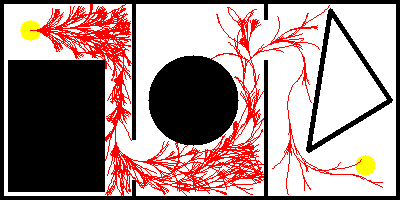

In [10]:
cv2_imshow(img_obstacles_mid)

# Trace the path

In [11]:
nodes_indices_to_travel = []
node_index = len(np_rrt_nodes) - 1
while node_index > 0:
    nodes_indices_to_travel.append(node_index)
    node_index = int(np_rrt_nodes[node_index, 4])
nodes_indices_to_travel.append(node_index)
nodes_indices_to_travel = nodes_indices_to_travel[::-1]

# Show the traced path (mid platform on RRT)

In [12]:
img_obstacles_copy = img_obstacles_mid.copy()
out = cv2.VideoWriter('NonHolonomic 2 - Mid platform on RRT.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, img_obstacles.shape[:2][::-1])
for n in range(len(nodes_indices_to_travel)-1):
    np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(np_rrt_nodes[nodes_indices_to_travel[n], :3], np_rrt_nodes[nodes_indices_to_travel[n+1], 3])
    for i in range(len(np_path)-1):
        img_obstacles_copy = cv2.line(img_obstacles_copy, tuple(np_path[i, :2].astype(np.int))[::-1], tuple(np_path[i+1, :2].astype(np.int))[::-1], (0, 255, 0), 1)
        # img_obstacles_copy = cv2.line(img_obstacles_copy, tuple(np_path_wheel_1[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_1[i+1, :2].astype(np.int))[::-1], (0, 0, 255), 1)
        # img_obstacles_copy = cv2.line(img_obstacles_copy, tuple(np_path_wheel_2[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_2[i+1, :2].astype(np.int))[::-1], (255, 0, 0), 1)
        # cv2_imshow(img_obstacles_copy)
        out.write(img_obstacles_copy.astype(np.uint8))
out.release()

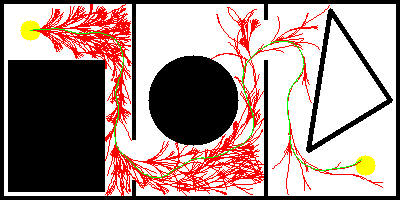

In [13]:
cv2_imshow(img_obstacles_copy)

# Show the traced path (all wheels)

In [14]:
img_obstacles_copy = img_obstacles.copy()
out = cv2.VideoWriter('NonHolonomic 3 - Path traced all wheels.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, img_obstacles.shape[:2][::-1])
for n in range(len(nodes_indices_to_travel)-1):
    np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(np_rrt_nodes[nodes_indices_to_travel[n], :3], np_rrt_nodes[nodes_indices_to_travel[n+1], 3])
    for i in range(len(np_path)-1):
        img_obstacles_copy = cv2.line(img_obstacles_copy, tuple(np_path[i, :2].astype(np.int))[::-1], tuple(np_path[i+1, :2].astype(np.int))[::-1], (0, 255, 0), 1)
        img_obstacles_copy = cv2.line(img_obstacles_copy, tuple(np_path_wheel_1[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_1[i+1, :2].astype(np.int))[::-1], (0, 0, 255), 1)
        img_obstacles_copy = cv2.line(img_obstacles_copy, tuple(np_path_wheel_2[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_2[i+1, :2].astype(np.int))[::-1], (255, 0, 0), 1)
        # cv2_imshow(img_obstacles_copy)
        out.write(img_obstacles_copy.astype(np.uint8))
out.release()

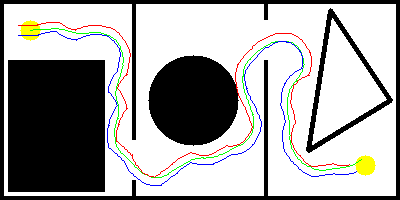

In [15]:
cv2_imshow(img_obstacles_copy)

# Show the traced path (with robot)

In [16]:
out = cv2.VideoWriter('NonHolonomic 4 - Path traced with robot.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, img_obstacles.shape[:2][::-1])
for n in range(len(nodes_indices_to_travel)-1):
    np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(np_rrt_nodes[nodes_indices_to_travel[n], :3], np_rrt_nodes[nodes_indices_to_travel[n+1], 3])
    for i in range(len(np_path)):
        img_obstacles_copy = img_obstacles.copy()
        cv2.line(img_obstacles_copy, tuple(np_path[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_1[i, :2].astype(np.int))[::-1], (0, 0, 255), 1)
        cv2.line(img_obstacles_copy, tuple(np_path[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_2[i, :2].astype(np.int))[::-1], (0, 0, 255), 1)
        cv2.line(img_obstacles_copy, tuple(np_path_wheel_1[i, :2].astype(np.int))[::-1], tuple(np_path_wheel_2[i, :2].astype(np.int))[::-1], (0, 0, 255), 1)
        # cv2_imshow(img_obstacles_copy)
        out.write(img_obstacles_copy.astype(np.uint8))
out.release()

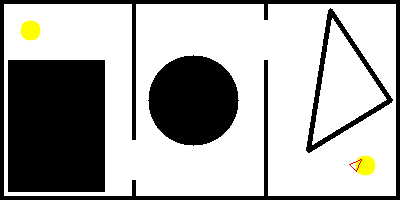

In [17]:
cv2_imshow(img_obstacles_copy)